In [1]:
# IMPORTS :

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# For Machine Learning :
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# DATABASE :

data = pd.read_csv('DATABASE.txt', sep=";", header=None, na_values=['?'])

data = data[:5000]

data = data.rename(columns=data.iloc[0]).drop(data.index[0])

data["Time_index2"] = data["Date"] + " " + data["Time"]

data["timestamp"] = pd.to_datetime(data['Time_index2'], format='%d/%m/%Y %H:%M:%S')
data.set_index(['timestamp'],inplace=True)

data["Global_active_power"] = data["Global_active_power"].astype(float)

data.head()

df = pd.DataFrame(data, columns=['Global_active_power'])

df = df.rename(columns={'Global_active_power': 'Y'})

data = df

df = df[:1261]

df.head()

C:\Users\bapti\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Y
timestamp,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


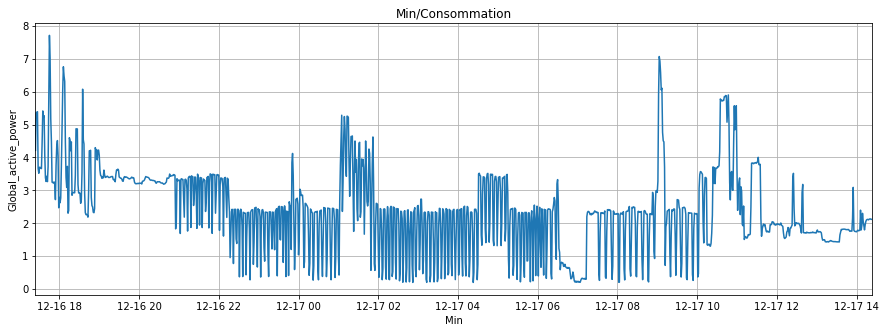

In [3]:
# See the plot :

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.title('Min/Consommation')
plt.ylabel('Global_active_power')
plt.xlabel('Min')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Y'])

In [4]:
# Data Preprocessing :

test_data_size = 60

all_data = data['Y'].values.astype(float)

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [5]:
# Data Normalization :

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

In [6]:
# Conversion for Pytorch :

train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [7]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [8]:
train_window = 60
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [9]:
#LSTM :

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [10]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Train :

epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

KeyboardInterrupt: 

In [13]:
# Predictions :

fut_pred = 60

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[-0.9911064505577087, -0.9952916502952576, -0.9905833005905151, -0.9958148002624512, -0.9905833005905151, -0.9963379502296448, -0.9911064505577087, -0.9958148002624512, -0.9911064505577087, -0.9926759004592896, -0.9952916502952576, -0.9911064505577087]


In [21]:
# Prédiction 60 -> 1

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1, 1))


SyntaxError: invalid syntax (<ipython-input-21-9506fdd7064a>, line 10)

In [22]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[0.8387076 ]
 [1.1468588 ]
 [1.30820638]
 [1.40063556]
 [1.45970228]
 [1.49876556]
 [1.52404074]
 [1.53994072]
 [1.54984549]
 [1.55603622]
 [1.55991431]
 [1.56233154]]


ValueError: x and y must have same first dimension, but have shapes (60,) and (12, 1)

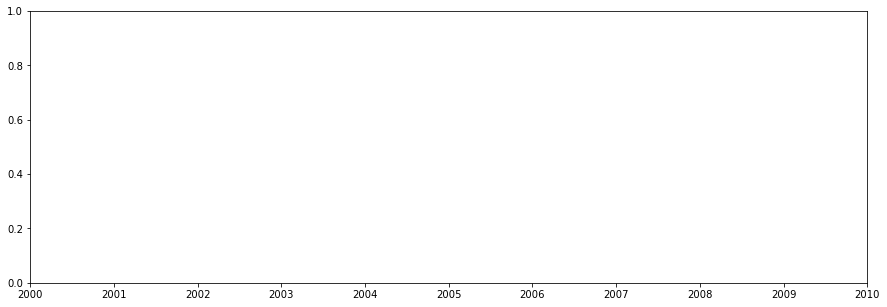

In [23]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

x = df.index[-test_data_size:]
plt.plot(x,actual_predictions)

plt.title('Min/Consommation')
plt.ylabel('Global_active_power')
plt.xlabel('Min')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Y'])